In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import get_data
import matplotlib.pyplot as plt
import population_activity as pop
import helper_functions as hf
import analysis
import plots
import statistics_test as st

from IPython.display import display, HTML
def print_large(text):
    display(HTML(f"<span style='font-size: 20px;'>{text}</span>"))
    


c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:

def analyze_data_common(datapath, reference, maps, analysis_type, method='subspace', compute_day11_12=False, 
                        transients=False, dim_red=False, max_dim=4, standardize='stand'):
    def get_analysis_function(analysis_type):
        if analysis_type == 'population_geometry':
            return analysis.populationgeometry, analysis.populationgeometry_context
        elif analysis_type == 'topology':
            return analysis.topology_analysis, analysis.topology_analysis_context


    analysis_func, context_func = get_analysis_function(analysis_type)

    def apply_analysis(func, *args):
        if analysis_type == 'population_geometry':
            return func(*args, method=method)
        else:
            return func(*args, max_dim=max_dim)

    hists = analysis.sort_maps_from_reference_AK(datapath, 'Context1', reference=reference, maps=maps, reference_type='no_reference',
                                                  hist='hist', transients=transients, dim_red=dim_red, 
                                                  standardize=standardize, remove_day_inactive=False)
    #hists=hists[::-1] 
    g = apply_analysis(analysis_func, hists)

    global_seeds = [1,2,3,4,5]
    simu_g_list = []
    for seed in global_seeds:
        simu_drift = analysis.simulate_drift(datapath, session='0', Context='Context1', days=len(maps)+1, 
                                             drift_type='circular', dim_red=dim_red, standardize=standardize, odd_even=True, 
                                             global_seed=seed, active_days=[reference]+maps, remove_day_inactive=True, 
                                             max_remap_prob=0.3, amplitude_drift_prob=0.3, amplitude_change_scale=0.5)
        simu_g = apply_analysis(analysis_func, simu_drift['maps'])
        simu_g_list.append(simu_g)
    simu_g_array = np.array(simu_g_list)
    simu_g = np.mean(simu_g_array, axis=0)

    hist_odd, hist_even = analysis.sort_maps_from_reference_within_session_AK(datapath, 'Context1', maps=maps, 
                                                                                  transients=transients, dim_red=dim_red,
                                                                                    standardize=standardize, remove_day_inactive=False)
    g_odd_even1 = apply_analysis(context_func, hist_odd, hist_even)

    if analysis_type == 'population_geometry':      

        shuff1, shuff2 = analysis.shuffle_two_sessions_hist(datapath, '0', '19', 'Context1', dim_red=dim_red, remove_inactive=[reference]+maps, 
                                                            standardize=standardize, remove_day_inactive=False)
        g_shuff1 = apply_analysis(context_func, [shuff1], [shuff2])

        
        g = (g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
        simu_g = (simu_g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
    else:
        g = g-g_odd_even1
        #g_odd_even1 = np.zeros_like(g)  
        #shuff2_sim = analysis.decoding2.circular_shuffle_features(simu_drift['maps'][-1].T).T
        #g_shuff_sim = apply_analysis(context_func, [simu_drift['maps'][0]], [shuff2_sim])

        #shuff1, shuff2 = analysis.circle_shuffle_two_sessions_hist(datapath, '0', '19', 'Context1', dim_red=dim_red, remove_inactive=[reference]+maps)
        #g_shuff1 = apply_analysis(context_func, [shuff1], [shuff2])
        #g = g /  np.max(simu_g)#/g_shuff_sim
        #simu_g = simu_g/  np.max(simu_g) #/ g_shuff_sim
  
    return g, simu_g


def collect_data(datapaths, reference, maps, analysis_type, method='subspace', compute_day11_12=False, transients=False, dim_red=False, max_dim=3, standardize='stand'):
    all_data = []
    for datapath in datapaths:
        data = analyze_data_common(datapath, reference, maps, analysis_type, method=method, compute_day11_12=compute_day11_12, transients=transients, dim_red=dim_red, max_dim=max_dim, standardize=standardize)
        all_data.append(data)
    return all_data

if __name__ == "__main__":
    datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 'D:/Antje_CA1/data_sig/51007.h5', 'D:/Antje_CA1/data_sig/63.h5', 'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
    transients = False
    dim_red = False
    max_dim = 4

    reference = '0'
    maps = [str(i) for i in np.arange(1, 13)] +  ['14', '15', '17', '19']
    forward_data_pop_geometry_subspace = collect_data(datapaths, reference, maps, 'population_geometry', method='subspace', compute_day11_12=False, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_pop_geometry_angles = collect_data(datapaths, reference, maps, 'population_geometry', method='angles', compute_day11_12=False, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_topology = collect_data(datapaths, reference, maps, 'topology', compute_day11_12=False, transients=transients, dim_red=dim_red, max_dim=max_dim, standardize='stand')



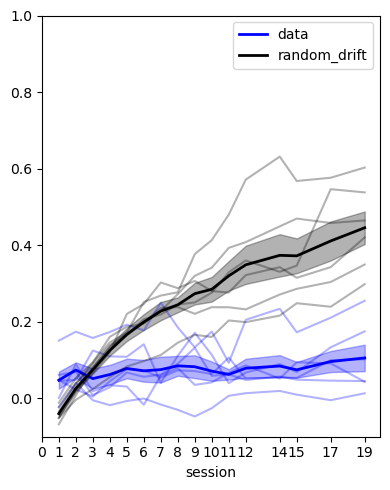

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,1.053608,15,75,0.070241,28.492554,6.421891e-25,0.000131,0.507114,0.123045
1,condition,1.318484,1,5,1.318484,24.372000,4.334045e-03,0.004334,0.562846,1.000000
2,time * condition,0.768201,15,75,0.051213,22.927203,4.676262e-22,0.000032,0.428624,0.169622


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,4.0405,0.0099,0.1587,,1.6495,Cohen's d,0.0476,-0.0398,0.0874,0.0530,6,True,0.1606
1,T2,C1,C2,t-test,2.3503,0.0655,1.0000,,0.9595,Cohen's d,0.0742,0.0256,0.0486,0.0506,6,True,0.0666
2,T3,C1,C2,t-test,-0.9052,0.4069,1.0000,,-0.3695,Cohen's d,0.0518,0.0747,-0.0229,0.0620,6,True,0.3326
3,T4,C1,C2,t-test,-2.4917,0.0550,0.8808,,-1.0172,Cohen's d,0.0624,0.1254,-0.0631,0.0620,6,True,0.4584
4,T5,C1,C2,t-test,-2.4620,0.0571,0.9134,,-1.0051,Cohen's d,0.0783,0.1668,-0.0885,0.0880,6,True,0.7110
5,T6,C1,C2,t-test,-2.8303,0.0367,0.5866,,-1.1555,Cohen's d,0.0720,0.1994,-0.1274,0.1103,6,True,0.2355
6,T7,C1,C2,t-test,-3.1452,0.0255,0.4083,,-1.2840,Cohen's d,0.0752,0.2281,-0.1529,0.1190,6,True,0.8314
7,T8,C1,C2,t-test,-4.3505,0.0074,0.1177,,-1.7761,Cohen's d,0.0851,0.2444,-0.1593,0.0897,6,True,0.3773
8,T9,C1,C2,t-test,-3.6638,0.0145,0.2326,,-1.4957,Cohen's d,0.0828,0.2736,-0.1908,0.1276,6,True,0.0619
9,T10,C1,C2,t-test,-5.0837,0.0038,0.0612,,-2.0754,Cohen's d,0.0713,0.2850,-0.2138,0.1030,6,True,0.3457


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.019806,15,0.001320,1.217173,0.278402,0.047494,0.226543
1,Error,0.081360,75,0.001085,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,1.802004,15,0.120134,33.239635,5.104150e-27,0.741919,0.104799
1,Error,0.271062,75,0.003614,NaN,NaN,NaN,NaN


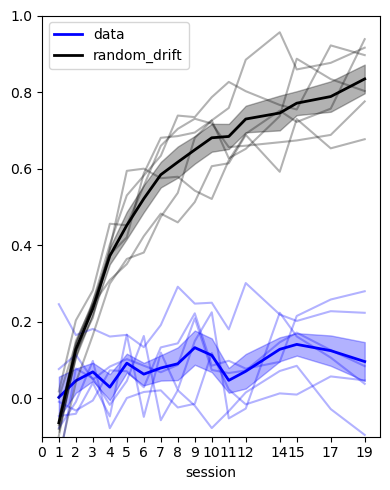

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,3.775123,15,75,0.251675,45.729473,1.601499e-31,3.970152e-08,0.719304,0.211432
1,condition,10.272437,1,5,10.272437,168.875811,4.810818e-05,4.810818e-05,0.874576,1.000000
2,time * condition,2.385384,15,75,0.159026,37.295815,1.274234e-28,1.865386e-07,0.618205,0.209569


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,1.5197,0.1891,1.0000,,0.6204,Cohen's d,0.0029,-0.0637,0.0666,0.1073,6,True,0.8274
1,T2,C1,C2,t-test,-2.9331,0.0325,0.5203,,-1.1974,Cohen's d,0.0462,0.1281,-0.0819,0.0684,6,True,0.9756
2,T3,C1,C2,t-test,-6.0158,0.0018,0.0292,*,-2.4559,Cohen's d,0.0694,0.2347,-0.1653,0.0673,6,True,0.7209
3,T4,C1,C2,t-test,-9.4653,0.0002,0.0036,**,-3.8642,Cohen's d,0.0294,0.3722,-0.3428,0.0887,6,True,0.4351
4,T5,C1,C2,t-test,-7.3444,0.0007,0.0117,*,-2.9983,Cohen's d,0.0921,0.4521,-0.3599,0.1200,6,True,0.9676
5,T6,C1,C2,t-test,-18.5695,8.3350e-06,0.0001,***,-7.5810,Cohen's d,0.0634,0.5216,-0.4582,0.0604,6,True,0.2086
6,T7,C1,C2,t-test,-8.8167,0.0003,0.0050,**,-3.5994,Cohen's d,0.0795,0.5843,-0.5047,0.1402,6,True,0.1842
7,T8,C1,C2,t-test,-9.4526,0.0002,0.0036,**,-3.8590,Cohen's d,0.0906,0.6172,-0.5266,0.1365,6,True,0.9946
8,T9,C1,C2,t-test,-9.3822,0.0002,0.0037,**,-3.8303,Cohen's d,0.1326,0.6492,-0.5165,0.1349,6,True,0.5558
9,T10,C1,C2,t-test,-24.7000,2.0287e-06,3.2460e-05,***,-10.0837,Cohen's d,0.1126,0.6807,-0.5680,0.0563,6,True,0.5684


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.140889,15,0.009393,1.984833,0.027558,0.145253,0.224222
1,Error,0.354914,75,0.004732,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,6.019618,15,0.401308,79.699261,9.419049e-40,0.903341,0.240053
1,Error,0.377646,75,0.005035,NaN,NaN,NaN,NaN


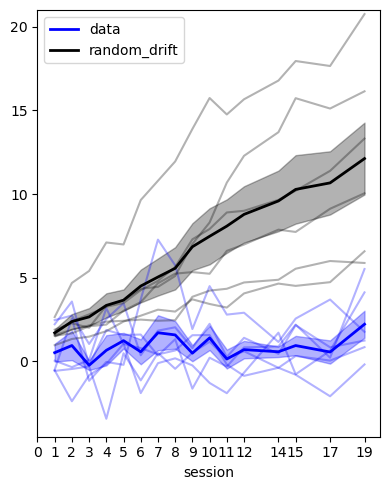

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,551.563923,15,75,36.770928,14.543184,1.643699e-16,0.002342,0.285056,0.112228
1,condition,1473.704663,1,5,1473.704663,22.765841,5.008789e-03,0.005009,0.515809,1.000000
2,time * condition,450.346741,15,75,30.023116,8.989012,1.833094e-11,0.003762,0.245592,0.151596


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-2.4428,0.0585,0.9353,,-0.9972,Cohen's d,0.5217,1.7088,-1.1871,1.1903,6,True,0.3964
1,T2,C1,C2,t-test,-1.7297,0.1442,1.0000,,-0.7062,Cohen's d,0.9505,2.3814,-1.4309,2.0263,6,True,0.5603
2,T3,C1,C2,t-test,-8.2796,0.0004,0.0067,**,-3.3801,Cohen's d,-0.2308,2.6603,-2.8911,0.8553,6,True,0.3838
3,T4,C1,C2,t-test,-2.3611,0.0647,1.0000,,-0.9639,Cohen's d,0.6637,3.3476,-2.6839,2.7844,6,True,0.9904
4,T5,C1,C2,t-test,-4.8601,0.0046,0.0741,,-1.9841,Cohen's d,1.2398,3.6610,-2.4211,1.2203,6,True,0.6081
5,T6,C1,C2,t-test,-2.9658,0.0313,0.5009,,-1.2108,Cohen's d,0.5751,4.5039,-3.9288,3.2449,6,True,0.5475
6,T7,C1,C2,t-test,-2.1357,0.0858,1.0000,,-0.8719,Cohen's d,1.7139,5.0435,-3.3296,3.8188,6,True,0.6854
7,T8,C1,C2,t-test,-2.5910,0.0488,0.7805,,-1.0578,Cohen's d,1.5843,5.5638,-3.9796,3.7623,6,True,0.9527
8,T9,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,0.4916,6.8523,-6.3607,3.4759,6,False,0.0315
9,T10,C1,C2,wilcoxon,0.0000,0.0312,0.5000,,0.8987,r,1.4056,7.4761,-6.0705,3.8098,6,False,0.0090


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,34.972102,15,2.331473,0.988048,0.476271,0.116098,0.207785
1,Error,176.975785,75,2.359677,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,966.938561,15,64.462571,18.372217,2.825856e-19,0.463971,0.087542
1,Error,263.152383,75,3.508698,NaN,NaN,NaN,NaN


In [3]:

# Subspace geometry analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: SUBSPACE angles')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_pop_geometry_subspace]
simu_g = [data[1] for data in forward_data_pop_geometry_subspace]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-0.1, 1], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData: ONE-WAY RM ANOVA')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift: oNE-WAY RM ANOVA')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

# Angles analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: Edge angles')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_pop_geometry_angles]
simu_g = [data[1] for data in forward_data_pop_geometry_angles]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-0.1, 1], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData:')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift:')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

# Topology analysis
print_large('\n' + '='*50)
print_large('RM ANOVA: Persistent homology')
print_large('='*50)
fig, ax = plt.subplots(figsize=(4, 5))
g = [data[0] for data in forward_data_topology]
simu_g = [data[1] for data in forward_data_topology]
plots.plot_average_geometry([g, simu_g], maps, colors=['b', 'k'], 
                          labels=['data', 'random_drift'], 
                          plot_individual=True, ylim=[-4.5, 21], ax=ax)
plt.show()  

print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([np.vstack(g), np.vstack(simu_g)])
display(anova[0])
display(anova[1])
print_large('\nData:')
display(st.repeated_measures_anova_single_condition(np.vstack(g)))
print_large('\nRandom Drift:')
display(st.repeated_measures_anova_single_condition(np.vstack(simu_g)))

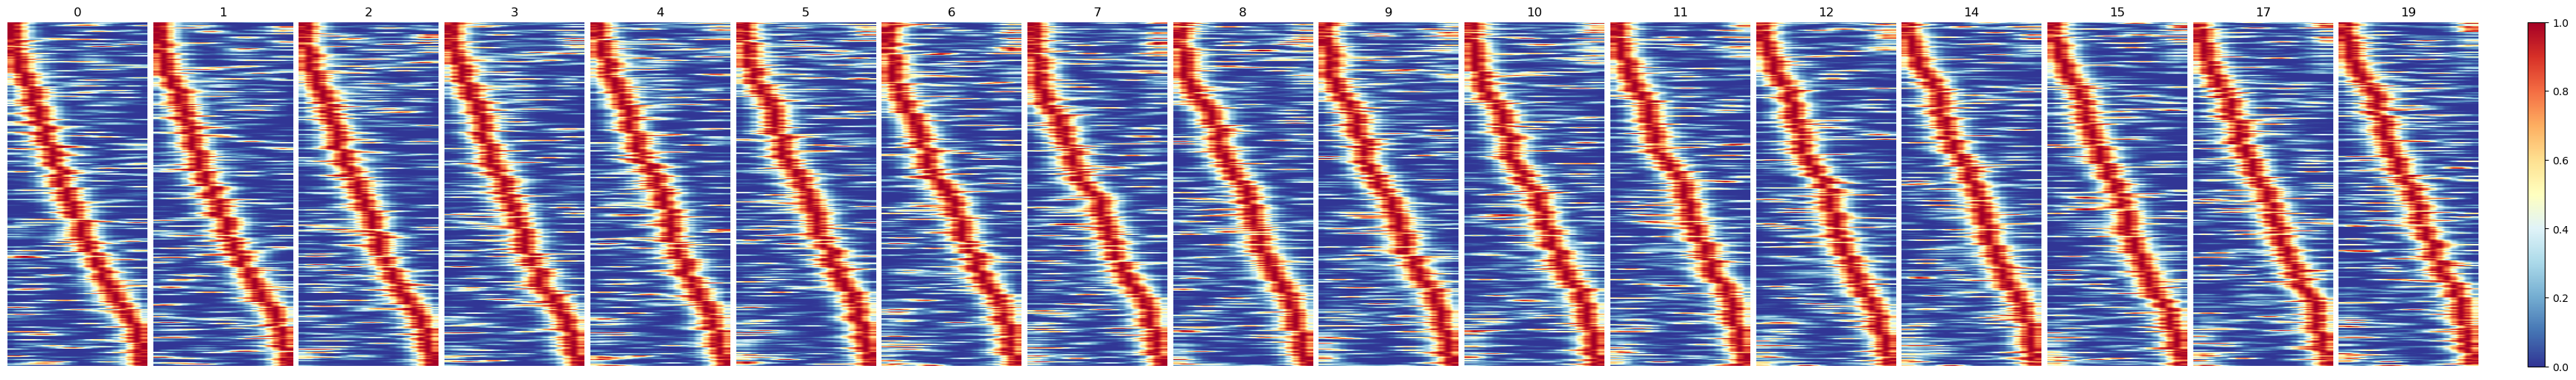

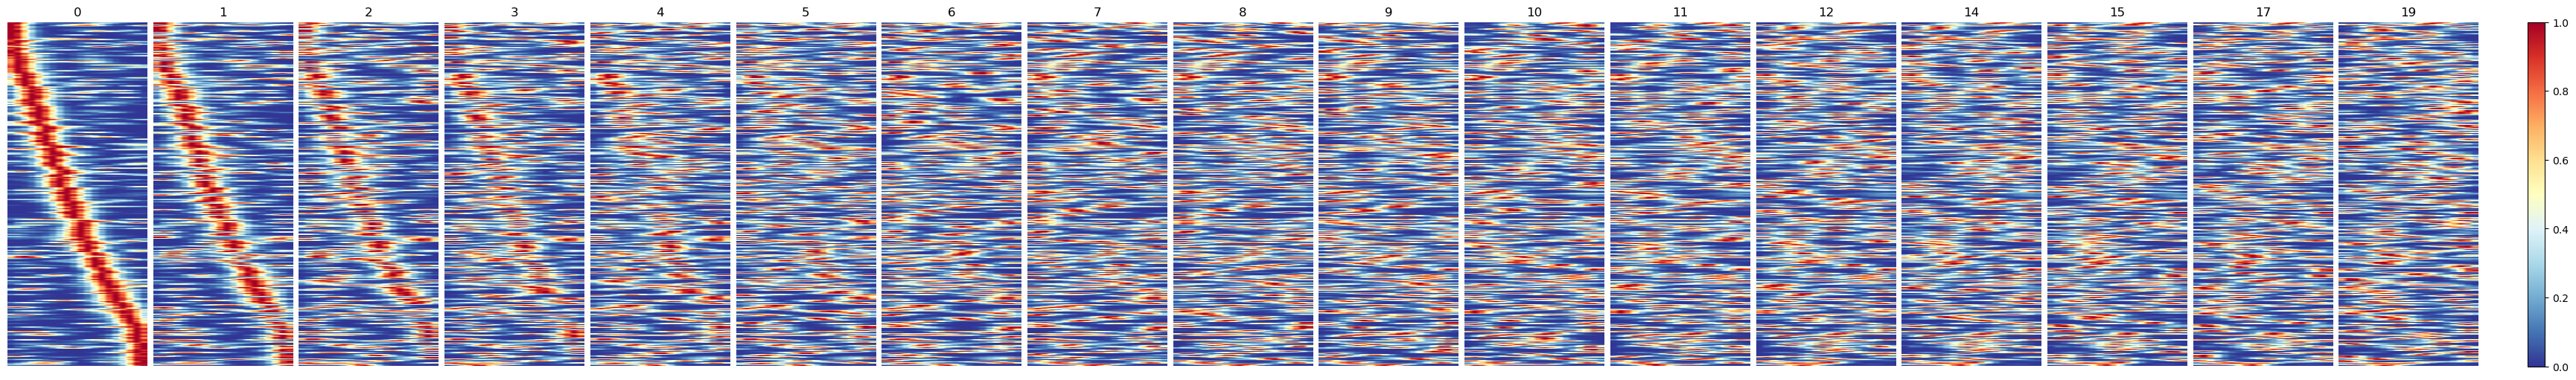

In [4]:
print_large('\n' + '='*50)
print_large('Drift simulation example')
print_large('='*50)

sim=analysis.simulate_drift('D:/Antje_CA1/data_sig/170.h5', session='0', Context='Context1',
                             days=len(maps)+1,  drift_type='circular',dim_red=False,
                               standardize='stand', odd_even=True, global_seed=0, active_days=[reference]+maps, remove_day_inactive=True, max_remap_prob=0.3, amplitude_drift_prob=0.3, amplitude_change_scale=0.75)
print_large('Sorted within days')
plots.plot_arrays([maps[sim['sorts'][d]] for d,maps in enumerate(sim['maps'])], ['0']+maps, remove_zero_rows=True)
print_large('Sorted with day1')
plots.plot_arrays([maps[sim['sorts'][0]] for maps in sim['maps']], ['0']+maps, remove_zero_rows=True)
before_correlation = [pop.ManifoldAnalysis.population_correlation( maps, sim['maps'][0] ) for maps in sim['maps'] ]
